<div>

<h1 style="text-align: center;">Data Exploratory and Analysis</h1>


# 1. Introduction
a very fist step in any data science project is to explore the data and understand it. This step helps know about data structure, data types, missing values and other critical information. It also transforms the data into a right format that machine learning models can understand. This notebook will present the exploratory data analysis of loan dataset that will be used to develop a robust model to predict loan approval status.

In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler

# setting global options
random_state = 12345 # set random state
plt.style.use('seaborn-v0_8-whitegrid')  # set plot style
set_config(transform_output = 'pandas') # set output pandas
start = time.time()

In [2]:
# read data from processed folder
loan = pd.read_csv('data/raw/raw_loan_data.csv')
meta_data = pd.read_csv('data/raw/metadata.txt', sep='\t', names=['id', 'description', 'type'])

In [3]:
target_status = meta_data.loc[meta_data.id == 'loan_status', 'id'].values.tolist()
target_score = meta_data.loc[meta_data.id == 'credit_score', 'id'].values.tolist()
num_features = meta_data.loc[(meta_data.type != 'Categorical') & (~meta_data.id.isin(['credit_score', 'loan_status'])), 'id'].values.tolist()
cat_features = meta_data.loc[(meta_data.type == 'Categorical'), 'id'].values.tolist()
print(f'target_status: has {len(target_status)} columns')
print(f'target_score: has {len(target_score)} columns')
print(f'num_features: has {len(num_features)} columns')
print(f'cat_features: has {len(cat_features)} columns')
display(target_status, target_score, num_features, cat_features)

target_status: has 1 columns
target_score: has 1 columns
num_features: has 7 columns
cat_features: has 5 columns


['loan_status']

['credit_score']

['person_age',
 'person_income',
 'person_emp_exp',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file']

# 2. Exploratory Data Analysis
## 2.1 Numerical Features

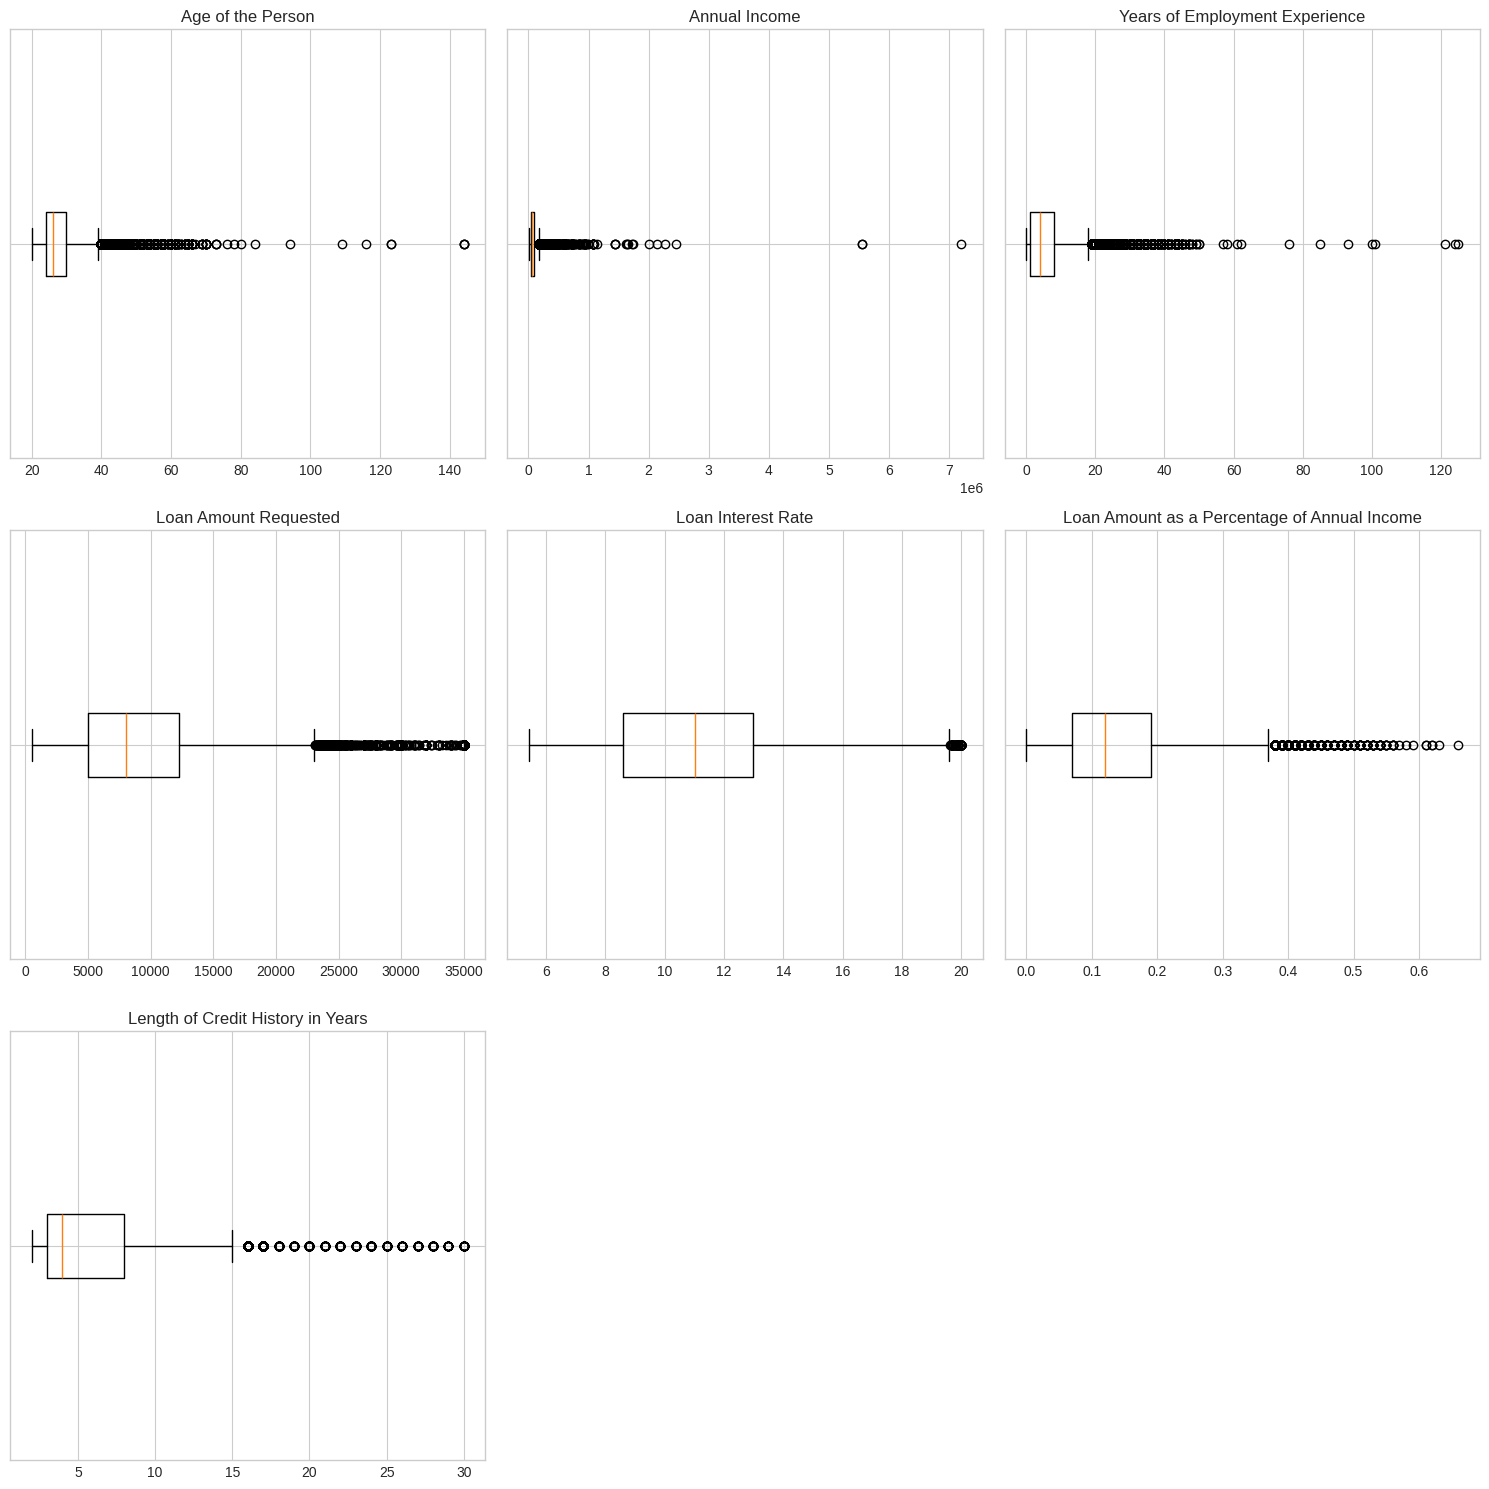

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Flatten axes to loop over
axes = axes.flatten()

for i, feature in enumerate(num_features):
    axes[i].boxplot(loan[feature], vert=False)
    axes[i].set_title(meta_data.loc[meta_data.id == feature, 'description'].values[0])
    axes[i].tick_params(axis='y', labelleft=False)  # Turn off y-tick labels

# delete unused axes
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

The figure shows that there are differenet scale among the numerical features. For example, The loan amount requested is ranging from 500 to 35K, while the iterest rate is ranging from 5.42% to 20.0%. Additionally, there are outlier presented in dataset for example, some clients has age of more than 100 years old and some clients have years of employment experience more than 80 years. These numbers are not practical and should be treated as outliers. 

## 2.2 Categorical Features

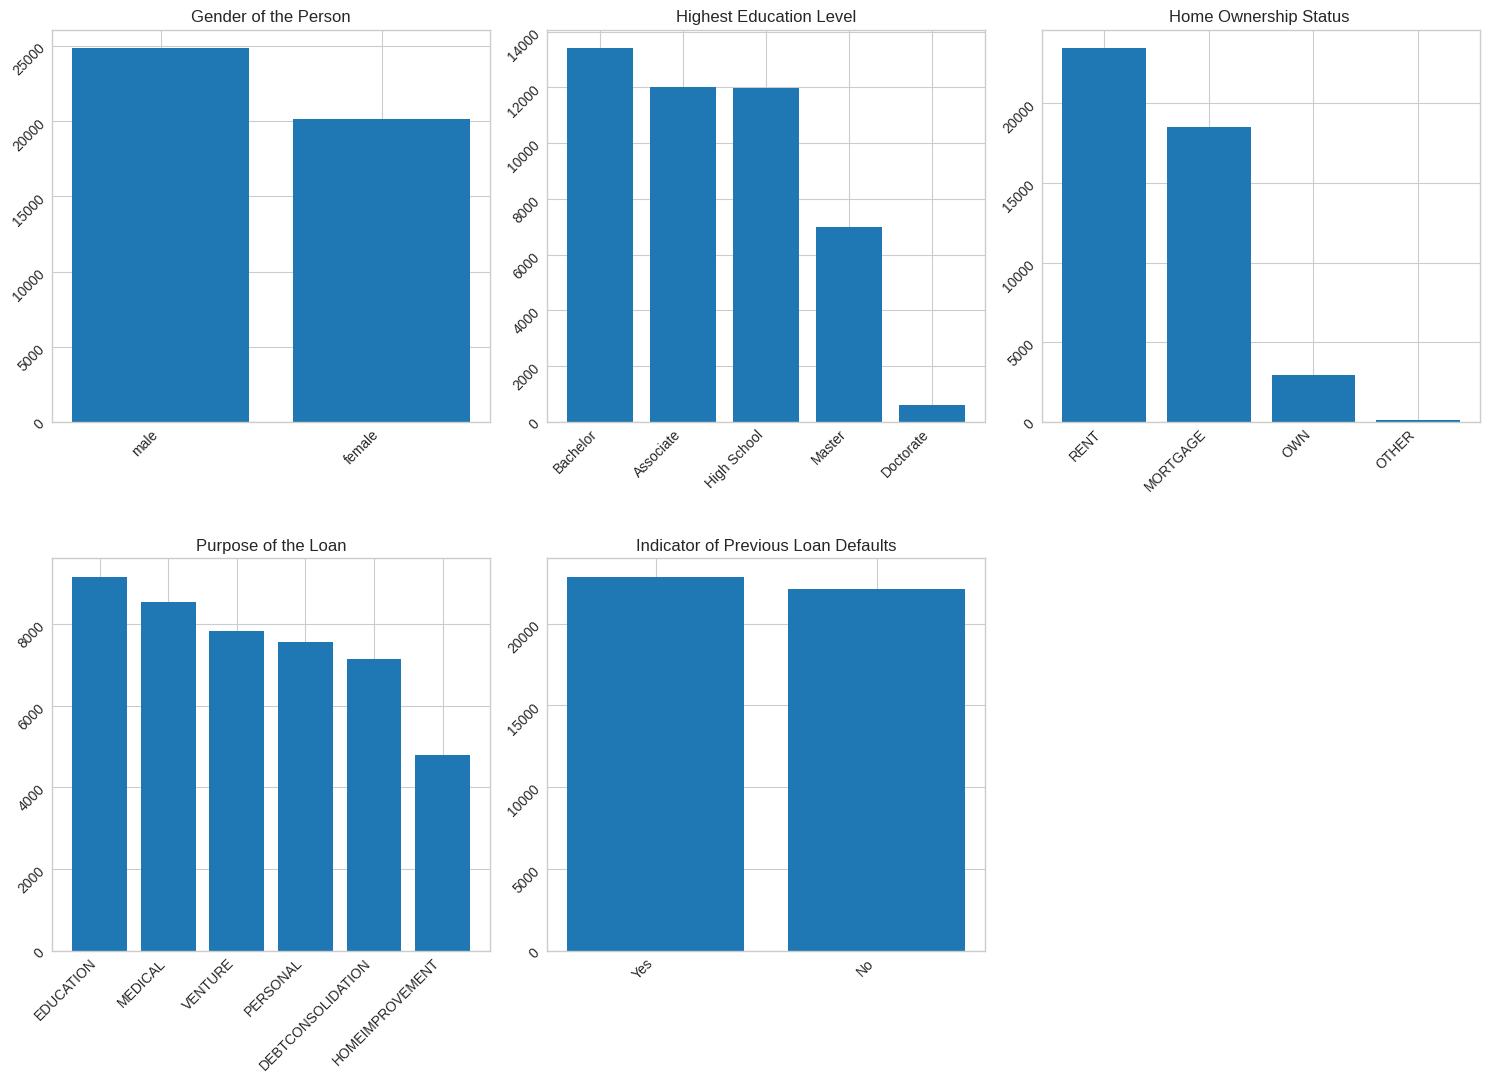

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Flatten axes to loop over
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    value_counts = loan[feature].value_counts().sort_values(ascending=False)
    axes[i].bar(value_counts.index, value_counts.values)  # Provide both y (categories) and width (counts)
    axes[i].set_title(meta_data.loc[meta_data.id == feature, 'description'].values[0])
    
    axes[i].set_xticks(range(len(value_counts)))  # Set x-ticks to be at the center of each bar
    axes[i].set_xticklabels(value_counts.index, ha='right', rotation = 45)  # Rotate x-tick labels

    # axes[i].set_yticks(range(0, value_counts.max(), 5000))  # Set y-ticks to be at the center of each bar
    # axes[i].set_yticklabels(range(0, value_counts.max(), 5000), rotation = 45)  # Rotate x-tick labels

    axes[i].tick_params(axis='y', labelrotation=45)  # Rotate x-tick labels
# hide unused axes
for j in range(len(cat_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

As it can be seen from the above figure, the dataset contains 5 categorical features. Four of them are nominal variables including gender, hoome ownership status, purpose fo the loan and indicator of previous loan defaults. The ordinal varibale is the highest level of education. Additionally, these varibales are presented as text. Therefore, these varibales need to be encoded t numerical values. Due to their nature, one-hot-encoding will be used for nominal varibale and ordinal encoding will be used for ordinal variable. 

## 3. Target Variables

/tmp/ipykernel_24584/3582965569.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([loan.loc[loan[target_status[0]] == 0, target_score[0]].dropna(),


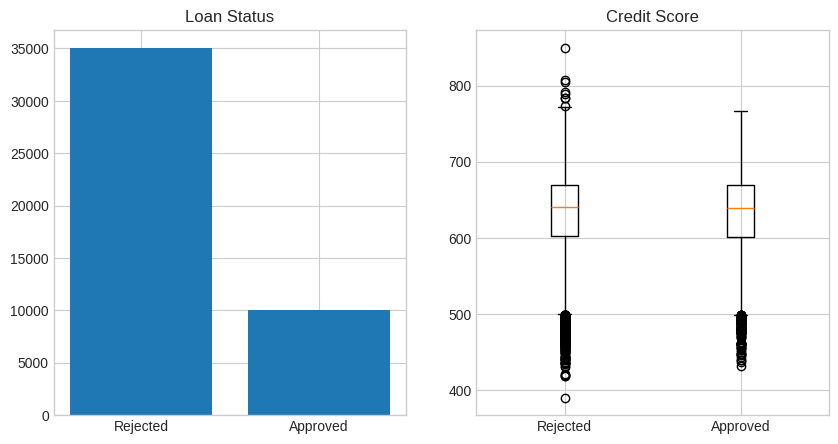

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(['Rejected', 'Approved'], loan[target_status].value_counts().values)
axes[0].set_title('Loan Status')
axes[1].boxplot([loan.loc[loan[target_status[0]] == 0, target_score[0]].dropna(),
                 loan.loc[loan[target_status[0]] == 1, target_score[0]].dropna()],
                labels=['Rejected', 'Approved'])
axes[1].set_title('Credit Score')
plt.show()

It can be seen from the graph that there is an imbalance in loan status target variable. The number of people had been rejected loan application is three times higher than the ones who had been approved. Regarding credit score varibale, as can bee seen from the left figure, the distribution of credit score over the loan status is similar. Thus, it can be said that the loan application approval rate is denpended on other factors.

The task for this dataset is to develop model to predict credit score and loan application status for potential clients. Due to imbalanced target variable, stratified resampling should be use to split dataset into training, validation and test set.

# 3. Data Processing
The data exploratory informs that:
- There are outlier presented in the dataset.
- All nummerical features should rescaled use standard scaler.
- The highest level of education is ordinal variable and should be encoded as ordinal values.
- Gender, Home ownership status, purpose of the loan and indicator of previous loan defaults are nominal variables and should be encoded as nominal values.
- We have to use strafitied resampling to split the dataset.

## 3.1 Data Preprocessing
The data processing pipe will be:
    - Split the dataset into train, validation and test set
    - Transform data
    - Remove outliers
    - Saving processed data for further use

In [7]:
# split data into train and test
train_set, tempt_set = train_test_split(loan, test_size=0.3, random_state=random_state, stratify=loan[target_status])
val_set, test_set = train_test_split(tempt_set, test_size=0.5, random_state=random_state, stratify=tempt_set[target_status])
train_set.shape, val_set.shape, test_set.shape


((31500, 14), (6750, 14), (6750, 14))

In [8]:
# define the preprocessing pipeline
one_hot_variables = [feature for feature in cat_features if feature != 'person_education']

# column transformer
preprocessing = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories=[['High School', 'Bachelor', 'Master', 'Associate', 'Doctorate']]), ['person_education']),
        ('one_hot_encoder', OneHotEncoder(drop='first', sparse_output=False), one_hot_variables),
        ('min_max_scaler', MinMaxScaler(), num_features + ['credit_score']),
    ],
    remainder='passthrough'
)
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal_encoder',
                                 OrdinalEncoder(categories=[['High School',
                                                             'Bachelor',
                                                             'Master',
                                                             'Associate',
                                                             'Doctorate']]),
                                 ['person_education']),
                                ('one_hot_encoder',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['person_gender', 'person_home_ownership',
                                  'loan_intent',
                                  'previous_loan_defaults_on_file']),
                                ('min_max_scaler', MinMaxScaler(),
                                 ['person_age', 'person_income',
                                  'person_emp_exp', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length',
                                  'credit_score'])])

In [9]:
# transform the data
train_set = preprocessing.fit_transform(train_set)
val_set = preprocessing.transform(val_set)
test_set = preprocessing.transform(test_set)
train_set.shape, val_set.shape, test_set.shape

((31500, 20), (6750, 20), (6750, 20))

In [10]:
# train outlier detector
new_num_features = [f'min_max_scaler__{feature}' for feature in num_features]

outlier_detector = IsolationForest(contamination=0.0009, random_state=random_state)
outlier_detector.fit(train_set[new_num_features])

# predict outliers
train_set['outlier'] = outlier_detector.fit_predict(train_set[new_num_features])
val_set['outliers'] = outlier_detector.predict(val_set[new_num_features])
test_set['outliers'] = outlier_detector.predict(test_set[new_num_features])

In [11]:
train_set['outlier'].value_counts(), val_set['outliers'].value_counts(), test_set['outliers'].value_counts()

(outlier
  1    31471
 -1       29
 Name: count, dtype: int64,
 outliers
  1    6746
 -1       4
 Name: count, dtype: int64,
 outliers
  1    6746
 -1       4
 Name: count, dtype: int64)

In [12]:
train_set = train_set.drop(index=train_set.loc[train_set['outlier'] == -1].index, columns='outlier')
val_set = val_set.drop(index=val_set.loc[val_set['outliers'] == -1].index, columns='outliers')
test_set = test_set.drop(index=test_set.loc[test_set['outliers'] == -1].index, columns='outliers')
train_set.shape, val_set.shape, test_set.shape

((31471, 20), (6746, 20), (6746, 20))

In [13]:
# Define paths for raw and processed data
processed_data_path = '/mnt/d/torch-playground/data/processed'

# Create processed folder
os.makedirs(processed_data_path, exist_ok=True)

train_set.to_csv(os.path.join(processed_data_path, 'loan_train.csv'), index=False)
val_set.to_csv(os.path.join(processed_data_path, 'loan_val.csv'), index=False)
test_set.to_csv(os.path.join(processed_data_path, 'loan_test.csv'), index=False)

print("Process data has been saved to the processed folder.")

Process data has been saved to the processed folder.


# 4. Conclusion
This note book  presents step by step data exploartory and analysis for loan dataset. The analysis use three main libraries: Pandas, Scikit-Learn and Matplotlib. The raw data has been processed use following algorithms: Isolation Forest, One-Hot-Encoding, Ordinal Encoding and Standard Scaler. The processed data has been saved for further use.

In [14]:
end = time.time()
print(f'Total running time: {end - start}')

Total running time: 2.286992311477661
